In [1]:
'''
Samuel Grant 2023

Working on understanding the track cuts in MeasureModuleEfficiency.py. 

'''

'\nSamuel Grant 2023\n\nWorking on understanding the track cuts in MeasureModuleEfficiency.py. \n\n'

In [3]:
# External
import os
import sys
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
import PrintUtils as pr

In [4]:
# Plot2D 
def Plot2D(x, y, nbinsX=100, xmin=-1.0, xmax=1.0, nbinsY=100, ymin=-1.0, ymax=1.0, min_box_coords=None, max_box_coords=None, box_colour="w", title=None, xlabel=None, ylabel=None, fout="hist.png", log=False, cb=True, NDPI=300):

    # Filter out empty entries from x and y
    valid_indices = [i for i in range(len(x)) if np.any(x[i]) and np.any(y[i])]

    # Extract valid data points based on the indices
    x = [x[i] for i in valid_indices]
    y = [y[i] for i in valid_indices]

    # Check if the input arrays are not empty and have the same length
    if len(x) == 0 or len(y) == 0:
        print("Input arrays are empty.")
        return
    if len(x) != len(y):
        print("Input arrays x and y have different lengths.")
        return

    # Create 2D histogram
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=[nbinsX, nbinsY], range=[[xmin, xmax], [ymin, ymax]])

    # Set up the plot
    fig, ax = plt.subplots()

    norm = colors.Normalize(vmin=0, vmax=np.max(hist))  
    if log: norm = colors.LogNorm(vmin=1, vmax=np.max(hist)) 

    # Plot the 2D histogram
    im = ax.imshow(hist.T, cmap='inferno', extent=[xmin, xmax, ymin, ymax], aspect='auto', origin='lower', norm=norm)  # , vmax=np.max(hist), norm=colors.LogNorm())
    # im = ax.imshow(hist.T, extent=[xmin, xmax, ymin, ymax], aspect='auto', origin='lower', vmax=np.max(hist))

    # Add colourbar
    if cb: plt.colorbar(im)

    # Draw a box if min_box_coords and max_box_coords are provided
    if min_box_coords and max_box_coords:
        x_min, y_min = min_box_coords
        x_max, y_max = max_box_coords
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, linestyle="--", edgecolor=box_colour, facecolor="none")
        ax.add_patch(rect)

    plt.title(title, fontsize=16, pad=10)
    plt.xlabel(xlabel, fontsize=14, labelpad=10)
    plt.ylabel(ylabel, fontsize=14, labelpad=10)

    ut.ScientificNotation(ax)

    plt.tight_layout()

    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()
    
    plt.close()
    
    print("\n---> Written:\n\t", fout)

    return

In [7]:
def Plot1D(data, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, fout="hist.png", legPos="best", log=False, stats=True, underOver=False, errors=False, NDPI=300):
    
    data = np.array(data)
    # data = np.flatten(data)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot the histogram with outline
    counts, bin_edges, _ = ax.hist(data, bins=nbins, range=(xmin, xmax), histtype='step', edgecolor='black', linewidth=1.0, fill=False, density=False)

    # Log scale 
    if log:
        ax.set_yscale('log')
        
    # Set x-axis limits
    ax.set_xlim(xmin, xmax)

    # Calculate statistics
    N, mean, meanErr, stdDev, stdDevErr, underflows, overflows = ut.GetBasicStats(data, xmin, xmax)

    # # Create legend text
    legendText = f"Entries: {N}\nMean: {ut.Round(mean, 3)}\nStd Dev: {ut.Round(stdDev, 3)}"
    if errors: legendText = f"Entries: {N}\nMean: {ut.Round(mean, 3)}$\pm${ut.Round(meanErr, 1)}\nStd Dev: {ut.Round(stdDev, 3)}$\pm${ut.Round(stdDevErr, 1)}"
    if underOver: legendText += f"\nUnderflows: {underflows}\nOverflows: {overflows}"

    # Add legend to the plot
    if stats: ax.legend([legendText], loc=legPos, frameon=False, fontsize=13)

    ax.set_title(title, fontsize=15, pad=10)
    ax.set_xlabel(xlabel, fontsize=13, labelpad=10) 
    ax.set_ylabel(ylabel, fontsize=13, labelpad=10) 

    # Set font size of tick labels on x and y axes
    ax.tick_params(axis='x', labelsize=13)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=13)  # Set y-axis tick label font size

    ut.ScientificNotation(ax)

    plt.tight_layout()

    plt.savefig(fout, dpi=NDPI, bbox_inches="tight")
    plt.show()

    # Clear memory
    plt.close()

    print("\n---> Written:\n\t", fout)

    return

In [5]:
# Get data
fileName="/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/81168767/00/00000/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000014.root" #"/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00038/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000006.root"
finTag = fileName.split('.')[-2] 
with uproot.open(fileName) as file:
    data_ = ut.GetData(file)

In [6]:
# Events at the end of the digitisation window get messed up
# Cut on start time 
def CutOnStartTime(arrays_, quiet=False): 
    if not quiet: print(f"\n---> Cutting on start time")
    startTimeCondition = ak.all(arrays_["crv"]["crvcoincs.timeStart"] <= 99500, axis=1)
    return arrays_[startTimeCondition]
    
# data_ = CutOnStartTime(data_)

In [7]:
# Filter particles
def FilterParticles(arrays_, particle, quiet=False):
    if not quiet: print(f"\n---> Filtering particles, keeping {particle}")
    
    muonCondition = ak.any((arrays_["crv"]["crvcoincsmc.pdgId"] == 13) | (arrays_["crv"]["crvcoincsmc.pdgId"] == -13), axis=1)
    if particle == "all":
        return arrays_
    elif particle == "muons": 
        return arrays_[muonCondition] 
    elif particle == "non_muons":
        return arrays_[~muonCondition] 
    else:
        raise ValueError(f"Particle string {particle} not valid!")

particle = "all"
# data_ = FilterParticles(data_, particle)

In [8]:
# Interesting event?
pr.PrintNEvents(data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 6837)])

print(len(ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"])))
# test2_ = data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 6837)]
# pr.PrintNEvents(test2_)

205233


In [9]:
# Basic config 
recon="MDC2020ae"
PE=10
particle="all"
layer=3

In [10]:
# testing: tracker planes
# sid: integer identifying the surface the track intersection
# sindex: index enumerating intersections with this surface (if there are >1)
unique_sid = set(ak.flatten(data_["trkfit"]["klfit"]["sid"], axis=None))
unique_sindex = set(ak.flatten(data_["trkfit"]["klfit"]["sindex"], axis=None))
print(unique_sid, unique_sindex)

{0, 2, 4, 200} {0, 1, 2}


In [ ]:
'''
Just raw data
'''
# sid=0
# # print(data_["trkfit"])
# data_["trkfit"] = data_["trkfit"][(data_["trkfit"]["klfit"]["sid"] == sid)]

ut.PrintNEvents(data_, 1)

length=-1

Plot2D(x=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
         , y=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
         , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
         # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
         , title="Raw", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
         , fout=f"../Images/{recon}/TrackCuts//h2_ZX_raw.png")

Plot2D(x=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
         , y=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
         , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
         # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
         , title="Raw", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
         , fout=f"../Images/{recon}/TrackCuts/h2_ZY_raw.png")

Plot2D(x=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
         , y=ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
         , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
         # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
         , title="Raw", xlabel="KKInter X [mm]", ylabel="KKInter Y [mm]"
         , fout=f"../Images/{recon}/TrackCuts//h2_XY_raw.png")

-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 14
evtinfo.event: 92
***** crv *****
crvcoincs.sectorType: []
crvcoincs.nLayers []
crvcoincs.angle: []
crvcoincs.pos.fCoordinates: ([], [], [])
crvcoincs.timeStart: []
crvcoincs.time: []
crvcoincs.PEs: []
crvcoincs.PEsPerLayer[4]: []
crvcoincs.nHits: []
crvcoincsmc.pdgId: []
crvcoincsmc.valid: []
crvcoincsmc.primaryE: []
***** trk *****
kl.status: [1]
kl.nactive: [12]
kl.nhits: [13]
kl.nplanes: [5]
kl.nnullambig: [3]
kl.ndof: [19]
kl.kl.fitcon: [0.695]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 3.46e+03, ...}, ..., {...}]]
klfit.sid: [[0, 2, 4, 4, 4, 200, 200, 200]]
klfit.sindex: [[0, 0, 0, 0, 0, 0, 1, 2]]
klkl: [[{d0: -153, phi0: -2.34, z0: -1.11e+03, theta: 2.36, mom: 2e+03, ...}, ...]]
klkl.z0err: [[0.371, 0.453, 0.453, 0.453, 0.371, 0.453, 0.453, 0.453]]
klkl.d0err: [[1.24, 1.24, 1.24, 1.24, 1.24, 1.24, 1.24, 1.24]]


In [25]:
# # With fiducial area cut
# def ApplyTrackerCuts(arrays_, fail=False, quiet=False):
    
#     if not quiet: print(f"\n---> Applying tracker cuts") 

#     # Mark cuts on the track and track fit level
#     arrays_["trkfit_KLCRV1"] = ( 
#         (arrays_["trkfit"]["klfit"]["sid"] == 200) 
#         & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

#     arrays_["trk_bestFit"] = ( 
#         (arrays_["trk"]["kl.ndof"] >= 10)
#         & (arrays_["trk"]["kl.fitcon"] > 0.1)
#         & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
#         & (arrays_["trk"]["kl.nplanes"] >= 4)
#         & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
#     arrays_["trkfit_bestFit"] = ( 
#         (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
#         & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

#     # CRV-T module overall length 6100 mm
#     # CRV-T module overall width 951.0 mm 
#     # Total layer offset 42.00*(4-1) = 127 mm
#     # TWO modules side-by-side w_tot = w + (N_mod-1)*(w_mod-off) 
#     # ---> 951 + (2-1)*(951-127) = 1775.0
#     # ---> 951 + (4-1)*(951-127) = 3423
#     # I thought there was supposed to be four in KPP?...
#     # Then we have a -500 mm offset in z
    
#     # min_box_coords = (-1775.0-500, -6100/2)
#     # max_box_coords = (1775.0-500, 6100/2)

#     arrays_["trkfit_CRV1Fiducial"] = ( 
#         (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) <= 6100/2)
#         & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) <= 3423/2) ) 
    
#     # arrays_["trkfit_CRV1Fiducial"] = ( 
#     #         (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 3388/2)
#     #         & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 2570/2) ) 
    
#     if not fail: 
#         # Create masks
#         arrays_["trkfit"] = arrays_["trkfit"][(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV1Fiducial"])]
#         arrays_["trk"] = arrays_["trk"][arrays_["trk_bestFit"]]
#     else: 
#         # Create masks
#         arrays_["trkfit"] = arrays_["trkfit"][~(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV1Fiducial"])]
#         arrays_["trk"] = arrays_["trk"][~arrays_["trk_bestFit"]]

#     # Check for a track in the event after cuts.
#     trkCut = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
#     # Check for a track fit in the event after cuts
#     trkFitCut = (
#         (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
#         & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
    
#     # Reset to event level
#     trkFitCut = ak.any(trkFitCut, axis=-1, keepdims=False) == True 

#     # Both do the same thing, but mark them pass/fail for bookkeeping.
#     if not fail: 
#         arrays_["pass_track_cuts"] = (trkCut & trkFitCut)
#         return arrays_[arrays_["pass_track_cuts"]]
#     else: 
#         arrays_["fail_track_cuts"] = (trkCut & trkFitCut)
#         return arrays_[arrays_["fail_track_cuts"]]

def ApplyTrackerCuts(arrays_, fail=False, crv1=False, quiet=False):
    
    if not quiet: print(f"\n---> Applying tracker cuts") 

    # Mark cuts on the track and track fit level
    arrays_["trkfit_KLCRV1"] = ( 
        (arrays_["trkfit"]["klfit"]["sid"] == 200) 
        & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

    arrays_["trk_bestFit"] = ( 
        (arrays_["trk"]["kl.ndof"] >= 10)
        & (arrays_["trk"]["kl.fitcon"] > 0.1)
        & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
        & (arrays_["trk"]["kl.nplanes"] >= 4)
        & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
    arrays_["trkfit_bestFit"] = ( 
        (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
        & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
        & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

    # CRV-T module overall length 6100 mm
    # CRV-T module overall width 951.0 mm 
    # Total layer offset 42.00*(4-1) = 127 mm
    # Four modules side-by-side w_tot = w + (N_mod-1)*(w_mod-off) 
    # ---> 951 + (3-1)*(951-127) = 1775.0
    # I thought there was supposed to be four in KPP?...
    # Then we have a -500 mm offset in z
    
    # min_box_coords = (-1775.0-500, -6100/2)
    # max_box_coords = (1775.0-500, 6100/2)

    # CRV-L-end length = 3388 mm
    # CRV-L-end width = 951 mm 
    # CRV-DS length = 2570 mm
    # CRV-DS width = 826 mm 
    
    # CRV-DS is rotated. length -> width. 
    # z: width for CRV-L
    # z: length for CRV-DS
    # x: width for CRV-DS
    # x: length for CRV-L
    
    # Total layer offset, off = 42.00*(4-1) = 127 mm
    # 2 modules w_tot = w_mod + (N_mod-1)*(w_mod-off) 
    # -500 offset in z
    
    # In x:
    # CRV-L-end width < CRV-DS length
    
    # In z:
    # CRV-L-end length > CRV-DS width
    
    # So the box is defined by:
    # x: CRV-DS length
    # z: CRV-L-end length
    
    # (z, x)
    # min_box_coords = (-(2570/2)-500, -(3388/2))
    # max_box_coords = (+(2570/2)-500, +(3388/2))

    # Measurement module
    arrays_["trkfit_CRV1Fiducial"] = ( 
        (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 6100/2) # ) 3423/2)
        & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 3423/2)) #) 

    # Trigger modules
    arrays_["trkfit_CRV23Fiducial"] = ( 
        (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 3388/2)
        & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 2570/2) ) 

    # Track condition 
    trkCondition = arrays_["trk_bestFit"]

    # Track fit (segments) condition 
    trkFitCondition = (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV23Fiducial"])
    if crv1:
        trkFitCondition = (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV1Fiducial"])
        
    if not fail: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][trkFitCondition] # (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV23Fiducial"])]
        arrays_["trk"] = arrays_["trk"][trkCondition] # arrays_["trk_bestFit"]]
    else: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][~trkFitCondition] # (arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"] & arrays_["trkfit_CRV23Fiducial"])]
        arrays_["trk"] = arrays_["trk"][~trkCondition] # arrays_["trk_bestFit"]]

    # Check for a track in the event after cuts.
    trkCut = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
    # Check for a track fit in the event after cuts
    trkFitCut = (
        (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
        & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
    
    # Reset to event level
    trkFitCut = ak.any(trkFitCut, axis=-1, keepdims=False) == True 

    # Both do the same thing, but mark them pass/fail for bookkeeping.
    if not fail: 
        arrays_["pass_track_cuts"] = (trkCut & trkFitCut)
        return arrays_[arrays_["pass_track_cuts"]]
    else: 
        arrays_["fail_track_cuts"] = (trkCut & trkFitCut)
        return arrays_[arrays_["fail_track_cuts"]]


---> Applying tracker cuts
-------------------------------------------------------------------------------------
***** evt *****
evtinfo.run: 1205
evtinfo.subrun: 14
evtinfo.eventid: 751
***** crv *****
crvcoincs.sectorType: [1]
crvcoincs.nLayers [4]
crvcoincs.angle: [0.326]
crvcoincs.pos.fCoordinates: ([-2.17e+03], [4.78e+03], [639])
crvcoincs.timeStart: [5.74e+04]
crvcoincs.time: [5.73e+04]
crvcoincs.PEs: [734]
crvcoincs.PEsPerLayer[4]: [[186, 169, 178, 201]]
crvcoincs.nHits: [16]
crvcoincsmc.pdgId: [13]
crvcoincsmc.valid: [True]
crvcoincsmc.primaryE: [2.62e+03]
***** trk *****
kl.status: [1]
kl.nactive: [15]
kl.nhits: [15]
kl.nplanes: [4]
kl.nnullambig: [0]
kl.ndof: [25]
kl.kl.fitcon: [0.897]
***** trkfit *****
klfit: [[{mom: {fCoordinates: {...}}, pos: {...}, time: 5.73e+04, momerr: ..., ...}]]
klfit.sid: [[200]]
klfit.sindex: [[1]]
klfit.time: [[5.73e+04]]
klkl: [[{d0: -408, phi0: -1.17, z0: -1.22e+03, theta: 1.91, mom: 2e+03, ...}]]
klkl.z0err: [[0.121]]
klkl.d0err: [[0.125]]
kl

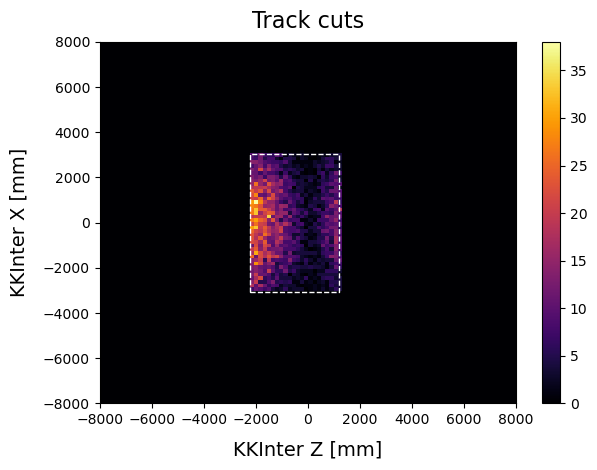


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_trkfit_ZX_track_cuts.png


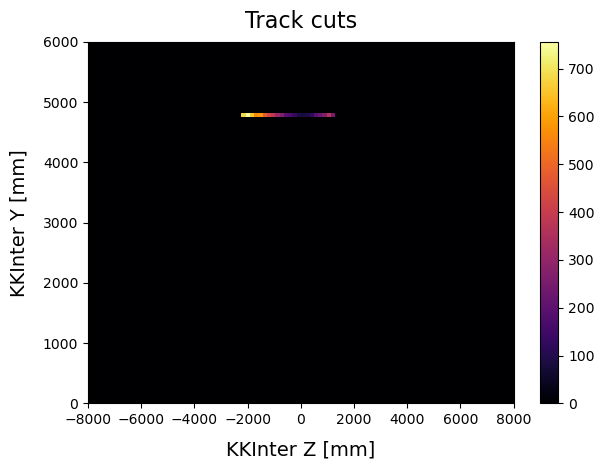


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_ZY_track_cuts.png


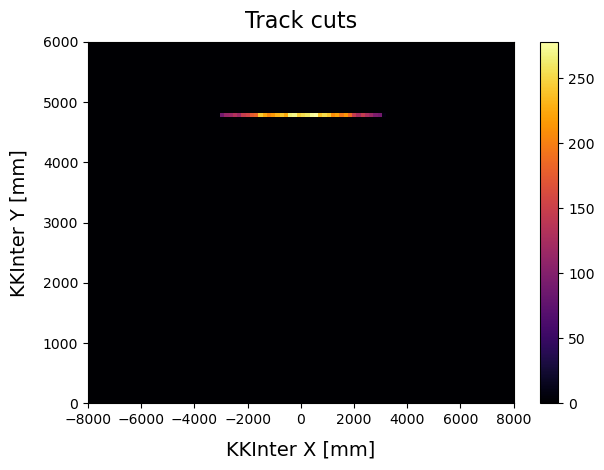


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_XY_track_cuts.png


In [29]:
'''
Track cuts only
'''

track_cuts_ = ak.copy(data_)
track_cuts_ = ApplyTrackerCuts(track_cuts_, crv1=True, fail=False)

pr.PrintNEvents(track_cuts_, 1, masks_ = ["pass_track_cuts", "trk_bestFit", "trkfit_bestFit", "trkfit_KLCRV1", "trkfit_CRV23Fiducial"] ) # "trkfit_CRV1Fiducial"])

print(len(track_cuts_))

min_box_coords = (-3423.0/2-500, -6100/2)
max_box_coords = (3423.0/2-500, 6100/2)

# min_box_coords = (-(2570/2)-500, -(3388/2))
# max_box_coords = (+(2570/2)-500, +(3388/2))

# Plot2D(x=ak.flatten(track_cuts_["crv"]["crvcoincs.pos.fCoordinates.fZ"], axis=None)#[:1000]
#        , y=ak.flatten(track_cuts_["crv"]["crvcoincs.pos.fCoordinates.fX"], axis=None)#[:1000]
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#        , min_box_coords=min_box_coords, max_box_coords=max_box_coords
#        , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#        , fout=f"../Images/{recon}/TrackCuts/h2_crv_ZX_track_cuts.png")

Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , min_box_coords=min_box_coords, max_box_coords=max_box_coords
       , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_trkfit_ZX_track_cuts.png")

Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts.png")

Plot2D(x=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts", xlabel="KKInter X [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts.png")

min_coords = (-437.1499938964844, -800.8499755859375)
max_coords = (-437.1499938964844, 800.8499755859375)


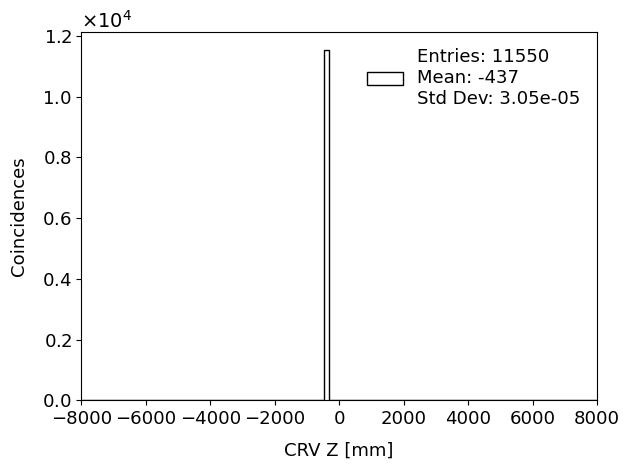


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h1_crvZ_raw.png


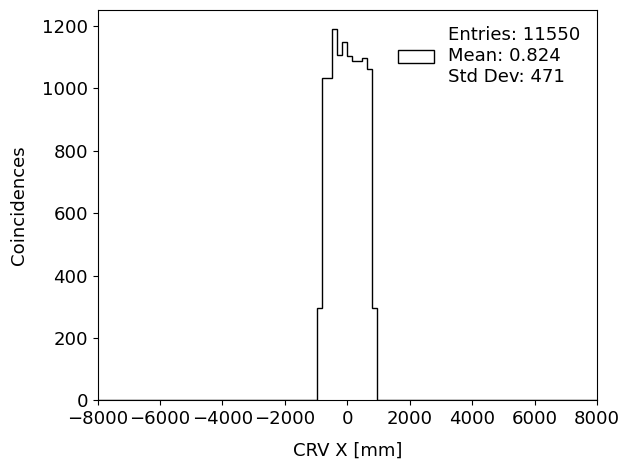


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h1_crvX_raw.png

            "min = -437.1499938964844"
            "max = -437.1499938964844"
            


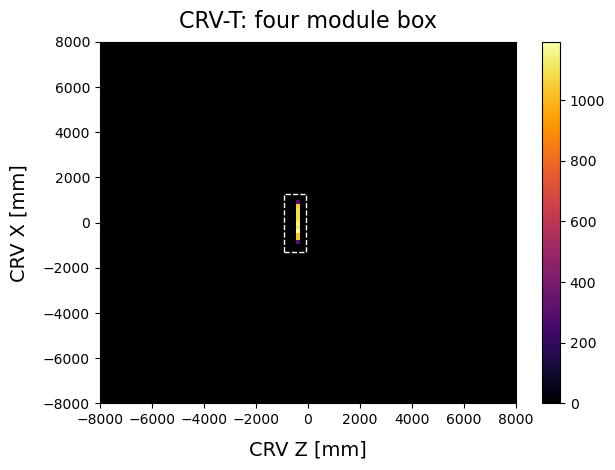


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_crvZX_four_modules.png


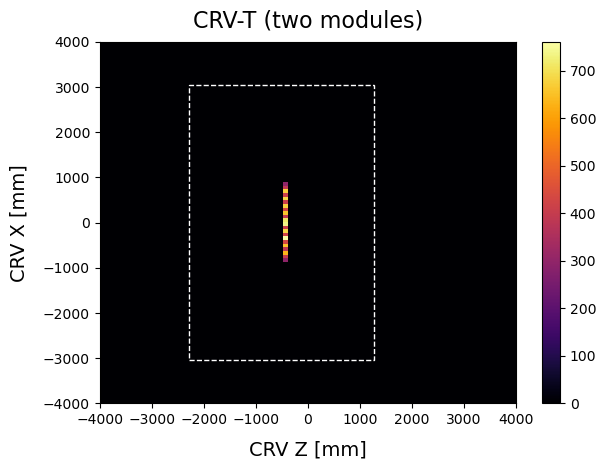


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_crvT_ZX_two_modules.png


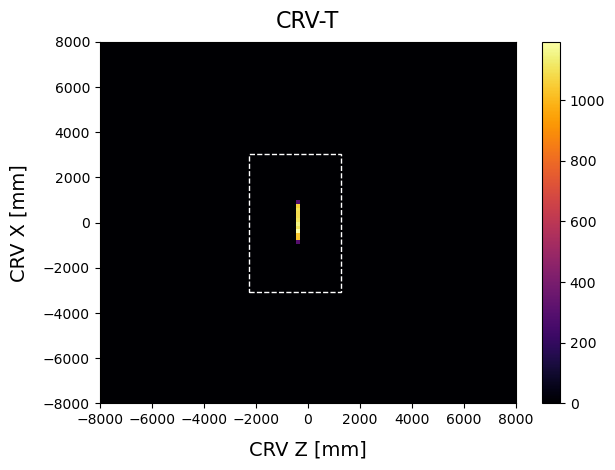


---> Written:
	 ../Images/MDC2020ae/TrackCuts/h2_crvZX_area.png


In [12]:
# Find CRV-T fiducial area

sector1Condition = data_["crv"]["crvcoincs.sectorType"] == 2

xCRVT = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fX"][sector1Condition], axis=None)
zCRVT = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sector1Condition], axis=None) 

min_box_coords = (np.min(zCRVT), np.min(xCRVT))
max_box_coords = (np.max(zCRVT), np.max(xCRVT))

print(f"min_coords = ({np.min(zCRVT)}, {np.min(xCRVT)})")
print(f"max_coords = ({np.max(zCRVT)}, {np.max(xCRVT)})")

Plot1D(zCRVT
       , nbins=100, xmin=-8000, xmax=8000
       , xlabel="CRV Z [mm]", ylabel="Coincidences"
       , fout=f"../Images/{recon}/TrackCuts/h1_crvZ_raw.png")

Plot1D(xCRVT
       , nbins=100, xmin=-8000, xmax=8000
       , xlabel="CRV X [mm]", ylabel="Coincidences"
       , fout=f"../Images/{recon}/TrackCuts/h1_crvX_raw.png")

outputStr = f"""
            "min = {np.min(zCRVT)}"
            "max = {np.max(zCRVT)}"
            """
print(outputStr)

# Plot2D(x=xCRVT, y=zCRVT
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#        , min_box_coords=min_box_coords, max_box_coords=max_box_coords
#        # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#        , title="Raw", xlabel="CRV Z [mm]", ylabel="CRV X [mm]"
#        , fout=f"../Images/{recon}/TrackCuts/h2_crvZX_raw.png", log=False)
# 826/2

#   arrays_["trkfit_CRV2Fiducial"] = ( 
#         (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) < 826/2)
#         & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) < 2570/2) 

      
min_box_coords = (-826/2-500, -2570/2)
max_box_coords = (826/2-500, 2570/2)

Plot2D(x=zCRVT, y=xCRVT
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , min_box_coords=min_box_coords, max_box_coords=max_box_coords
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="CRV-T: four module box", xlabel="CRV Z [mm]", ylabel="CRV X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_crvZX_four_modules.png", log=False)

# CRV-T module overall length 6100 mm
# CRV-T module overall width 951.0 mm 
# Total layer offset 42.00*(4-1) = 127 mm
# Four modules side-by-side w_tot = w + (N-1)*(w-off) = 951 + (4-1)*(951-127) = 3423.0
# Are there really four in this model?
# 951.0 + (2-1)*(951-127) = 3423.0

min_box_coords = (-1775.0-500, -6100/2)
max_box_coords = (1775.0-500, 6100/2)

Plot2D(x=zCRVT, y=xCRVT
       , nbinsX=100, xmin=-4000, xmax=4000, nbinsY=100, ymin=-4000, ymax=4000
       , min_box_coords=min_box_coords, max_box_coords=max_box_coords
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="CRV-T (two modules)", xlabel="CRV Z [mm]", ylabel="CRV X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_crvT_ZX_two_modules.png", log=False)

Plot2D(x=zCRVT, y=xCRVT
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , min_box_coords=min_box_coords, max_box_coords=max_box_coords
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="CRV-T", xlabel="CRV Z [mm]", ylabel="CRV X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_crvZX_area.png", log=False)


In [ ]:
'''
SID, sindex
Just to understand how this works.
'''

length=-1

for sid in [0, 2, 4, 200]:
    for sindex in [0, 1, 2]:
    
        sid_ = ak.copy(data_)
        # sid=200
        # sindex=1

        sid_["trkfit"] = sid_["trkfit"][(sid_["trkfit"]["klfit"]["sid"] == sid) & (sid_["trkfit"]["klfit"]["sindex"] == sindex)]

        # ut.PrintNEvents(sid_, 1)
        
        Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
                 , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
                 , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
                 # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
                 , title=f"Surface ID: {sid}; surface index: {sindex}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
                 , fout=f"../Images/{recon}/TrackCuts//h2_ZX_sid{sid}_sindex{sindex}.png")
        
        Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
                 , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
                 , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
                 # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
                 , title=f"Surface ID: {sid}; surface index: {sindex}", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
                 , fout=f"../Images/{recon}/TrackCuts/h2_ZY_sid{sid}_sindex{sindex}.png")
        
        Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
                 , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
                 , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
                 # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
                 , title=f"Surface ID: {sid}; surface index: {sindex}", xlabel="KKInter X [mm]", ylabel="KKInter Y [mm]"
                 , fout=f"../Images/{recon}/TrackCuts//h2_XY_sid{sid}_sindex{sindex}.png")

In [ ]:
# Find CRV-DS fiducial area

sector2Condition = data_["crv"]["crvcoincs.sectorType"] == 2

length=-1 # 1000
# Only have position info for Z in DS 
# xCRVDS = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sectorCondition], axis=None)[:length]
# xCRVDS = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sectorCondition], axis=None)[:length]
xCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fX"][sector2Condition], axis=None)[:length]
yCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fY"][sector2Condition], axis=None)[:length]
zCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sector2Condition], axis=None)[:length]

# CRV-DS length (z) = 2570 mm
# CRV-DS width (x) = 826 mm 
# Total layer offset, off = 42.00*(4-1) = 127 mm
# 2 modules w_tot = w_mod + (N_mod-1)*(w_mod-off) 
# Total width (x) = 826 + (2-1)*(826-127) = 1525
# -500 offset in z

l=2570
n_mod = 1
w_mod = 826
off = 127
w_tot = w_mod + (n_mod-1)*(w_mod-off)

min_box_coords = (-(l/2)-500, -(w_tot))
max_box_coords = (+(l/2)-500, +(w_tot))

Plot2D(x=zCRV, y=xCRV
       , nbinsX=100, xmin=-4000, xmax=4000, nbinsY=100, ymin=-4000, ymax=4000
       , min_box_coords=min_box_coords, max_box_coords=max_box_coords
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="CRV-DS (one module)", xlabel="CRV Z [mm]", ylabel="CRV X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_crvDS_ZX_one_module.png", log=False)

In [ ]:
# '''
# SID 0
# '''

# length=1e4

# sid_ = ak.copy(data_)
# sid=0
# sid_["trkfit"] = sid_["trkfit"][(sid_["trkfit"]["klfit"]["sid"] == sid)]

# ut.PrintNEvents(sid_, 1)

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_ZX_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts/h2_ZY_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_XY_sid{sid}.png")

In [ ]:
# '''
# SID 2 
# '''

# length=1e4

# sid_ = ak.copy(data_)
# sid=2
# sid_["trkfit"] = sid_["trkfit"][(sid_["trkfit"]["klfit"]["sid"] == sid)]

# ut.PrintNEvents(sid_, 1)

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_ZX_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts/h2_ZY_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_XY_sid{sid}.png")

In [ ]:
# '''
# SID 4
# '''

# length=1e4

# sid_ = ak.copy(data_)
# sid=4
# sid_["trkfit"] = sid_["trkfit"][(sid_["trkfit"]["klfit"]["sid"] == sid)]

# ut.PrintNEvents(sid_, 1)

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_ZX_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts/h2_ZY_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_XY_sid{sid}.png")

In [ ]:
# '''
# SID 200
# '''

# length=1e4

# sid_ = ak.copy(data_)
# sid=200
# sid_["trkfit"] = sid_["trkfit"][(sid_["trkfit"]["klfit"]["sid"] == sid)]

# ut.PrintNEvents(sid_, 1)

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_ZX_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts/h2_ZY_sid{sid}.png")

# Plot2D(x=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[:length]
#          , y=ak.flatten(sid_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[:length]
#          , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#          # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#          , title=f"Surface ID: {sid}", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#          , fout=f"../Images/{recon}/TrackCuts//h2_XY_sid{sid}.png")

In [ ]:
# # Original track cuts function
# def OriginalApplyTrackerCuts(arrays_, fail=False, quiet=False):
    
#     if not quiet: print(f"\n---> Applying tracker cuts") 
    
#     arrays_["trkfit_KLCRV1"] = ( 
#         (arrays_["trkfit"]["klfit"]["sid"] == 200) 
#         & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

#     arrays_["trk_bestFit"] = ( 
#         (arrays_["trk"]["kl.ndof"] >= 10)
#         & (arrays_["trk"]["kl.fitcon"] > 0.1)
#         & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
#         & (arrays_["trk"]["kl.nplanes"] >= 4)
#         & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
#     arrays_["trkfit_bestFit"] = ( 
#         (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
#         & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

#     # Apply cuts on the track and track fit level
#     if not fail: 
#         arrays_["trkfit"] = arrays_["trkfit"][(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
#         arrays_["trk"] = arrays_["trk"][arrays_["trk_bestFit"]]
#     else: 
#         arrays_["trkfit"] = arrays_["trkfit"][~(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
#         arrays_["trk"] = arrays_["trk"][~arrays_["trk_bestFit"]]

#     # These cuts are applied to trk and trkfit, events that fail will now have no track cut informatio.
#     # Mark events which still have tracks or track fits after cuts

#     arrays_["goodTrk"] = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
#     arrays_["goodTrkFit"] = (
#         (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
#         & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
    
#     # Reset to event level
#     arrays_["goodTrkFit"] = ak.any(arrays_["goodTrkFit"], axis=-1, keepdims=False) == True 

#     # Mark total track cuts
#     arrays_["pass_track_cuts"] = (arrays_["goodTrk"] & arrays_["goodTrkFit"])

#     # Return events passing/failing track fits
#     if not fail:  
#         return arrays_[arrays_["pass_track_cuts"]]
#     else:
#         return arrays_[~arrays_["pass_track_cuts"]]

In [ ]:
# # # Corrected track cuts function
# # '''
# # Original does not seem to work properly, it still returns events with no track information after cuts.
# # Also, we do NOT want to apply and event level cut based on the track fit objects.
# # Take care with the local fit parameters. What we return depends on pass/fail.

# # If we "fail" 

# # '''

# # def ApplyTrackerCuts(arrays_, fail=False, quiet=False):
    
# #     if not quiet: print(f"\n---> Applying tracker cuts") 

# #     # Mark cuts on the track and track fit level
# #     arrays_["trkfit_KLCRV1"] = ( 
# #         (arrays_["trkfit"]["klfit"]["sid"] == 200) 
# #         & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

# #     arrays_["trk_bestFit"] = ( 
# #         (arrays_["trk"]["kl.ndof"] >= 10)
# #         & (arrays_["trk"]["kl.fitcon"] > 0.1)
# #         & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
# #         & (arrays_["trk"]["kl.nplanes"] >= 4)
# #         & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
# #     arrays_["trkfit_bestFit"] = ( 
# #         (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
# #         & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
# #         & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
# #         & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

# #     if not fail: 
# #         # Create masks
# #         arrays_["trkfit"] = arrays_["trkfit"][(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
# #         arrays_["trk"] = arrays_["trk"][arrays_["trk_bestFit"]]
# #         # Check for a track in the event after cuts.
# #         passTrk = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
# #         # Check for a track fit in the event after cuts
# #         passTrkFit = (
# #             (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
# #             & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
# #         # Reset to event level
# #         passTrkFit = ak.any(passTrkFit, axis=-1, keepdims=False) == True 
# #         # Mark total track cuts
# #         arrays_["pass_track_cuts"] = (passTrk & passTrkFit)
# #         # Return events
# #         return arrays_[arrays_["pass_track_cuts"]]
# #     else: 
# #         # Create masks
# #         arrays_["trkfit"] = arrays_["trkfit"][~(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
# #         arrays_["trk"] = arrays_["trk"][~arrays_["trk_bestFit"]]
# #         # Check for a track in the event after cuts.
# #         arrays_["fail_trk"] = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
# #        # Check for a track fit in the event after cuts
# #         arrays_["fail_trkfit"] = (
# #             (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
# #             & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )

# #     # Check for a track in the event after cuts.
# #     arrays_["good_track"] = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 

# #     # Return events that sill contain tracks after passing/failing cuts.
# #     return arrays_[arrays_["has_track"]]

# # Corrected track cuts function
# '''

# Take care with the local fit parameters. What we return depends on pass/fail.

# If we "fail" 

# '''

# def OriginalApplyTrackerCuts2(arrays_, fail=False, quiet=False):
    
#     if not quiet: print(f"\n---> Applying tracker cuts") 

#     # Mark cuts on the track and track fit level
#     arrays_["trkfit_KLCRV1"] = ( 
#         (arrays_["trkfit"]["klfit"]["sid"] == 200) 
#         & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

#     arrays_["trk_bestFit"] = ( 
#         (arrays_["trk"]["kl.ndof"] >= 10)
#         & (arrays_["trk"]["kl.fitcon"] > 0.1)
#         & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
#         & (arrays_["trk"]["kl.nplanes"] >= 4)
#         & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
#     arrays_["trkfit_bestFit"] = ( 
#         (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
#         & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
#         & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )

#     if not fail: 
#         # Create masks
#         arrays_["trkfit"] = arrays_["trkfit"][(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
#         arrays_["trk"] = arrays_["trk"][arrays_["trk_bestFit"]]
#     else: 
#         # Create masks
#         arrays_["trkfit"] = arrays_["trkfit"][~(arrays_["trkfit_bestFit"] & arrays_["trkfit_KLCRV1"])]
#         arrays_["trk"] = arrays_["trk"][~arrays_["trk_bestFit"]]

#     # Check for a track in the event after cuts.
#     trkCut = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
#     # Check for a track fit in the event after cuts
#     trkFitCut = (
#         (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
#         & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )
    
#     # Reset to event level
#     trkFitCut = ak.any(trkFitCut, axis=-1, keepdims=False) == True 

#     # Both do the same thing, but mark them pass/fail for bookkeeping.
#     if not fail: 
#         arrays_["pass_track_cuts"] = (trkCut & trkFitCut)
#         return arrays_[arrays_["pass_track_cuts"]]
#     else: 
#         arrays_["fail_track_cuts"] = (trkCut & trkFitCut)
#         return arrays_[arrays_["fail_track_cuts"]]

In [ ]:
# Find CRV-L-end fiducial area

sector3Condition = data_["crv"]["crvcoincs.sectorType"] == 3

length=-1 #1000
# Only have position info for Z in DS 
# xCRVDS = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sectorCondition], axis=None)[:length]
# xCRVDS = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sectorCondition], axis=None)[:length]
xCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fX"][sector3Condition], axis=None)[:length]
yCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fY"][sector3Condition], axis=None)[:length]
zCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sector3Condition], axis=None)[:length]

# CRV-L-end length (x) = 3388 mm
# CRV-L-end width (z) = 951 mm 
# Total layer offset, off = 42.00*(4-1) = 127 mm
# 2 modules w_tot = w_mod + (N_mod-1)*(w_mod-off) 
# -500 offset in z

l=3388
n_mod = 1
w_mod = 951
off = 127
w_tot = w_mod + (n_mod-1)*(w_mod-off)

min_box_coords = (-(w_tot)-500, -(l/2))
max_box_coords = (+(w_tot)-500, +(l/2))

Plot2D(x=zCRV, y=xCRV
       , nbinsX=100, xmin=-4000, xmax=4000, nbinsY=100, ymin=-4000, ymax=4000
       , min_box_coords=min_box_coords, max_box_coords=max_box_coords
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="CRV-L-end (one module)", xlabel="CRV Z [mm]", ylabel="CRV X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_crvL_ZX_one_module.png", log=False)

In [ ]:
# Find CRV-DS fiducial area

sector3Condition = data_["crv"]["crvcoincs.sectorType"] == 3
sector2Condition = data_["crv"]["crvcoincs.sectorType"] == 2

length=-1 # 1000
# Only have position info for Z in DS 
# xCRVDS = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sectorCondition], axis=None)[:length]
# xCRVDS = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sectorCondition], axis=None)[:length]
xCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fX"][sector2Condition | sector3Condition], axis=None)[:length]
yCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fY"][sector2Condition | sector3Condition], axis=None)[:length]
zCRV = ak.flatten(data_["crv"]["crvcoincs.pos.fCoordinates.fZ"][sector2Condition | sector3Condition], axis=None)[:length]


# CRV-L-end length = 3388 mm
# CRV-L-end width = 951 mm 
# CRV-DS length = 2570 mm
# CRV-DS width = 826 mm 

# CRV-DS is rotated. length -> width. 
# z: width for CRV-L
# z: length for CRV-DS
# x: width for CRV-DS
# x: length for CRV-L

# Total layer offset, off = 42.00*(4-1) = 127 mm
# 2 modules w_tot = w_mod + (N_mod-1)*(w_mod-off) 
# -500 offset in z

# In x:
# CRV-L-end width < CRV-DS length

# In z:
# CRV-L-end length > CRV-DS width

# So the box is defined by:
# x: CRV-DS length
# z: CRV-L-end length

l=3388
n_mod = 1
w_mod = 951
off = 127
w_tot = w_mod + (n_mod-1)*(w_mod-off)

# should be (z, x)
min_box_coords = (-(2570/2)-500, -(3388/2))
max_box_coords = (+(2570/2)-500, +(3388/2))

Plot2D(x=zCRV, y=xCRV
       , nbinsX=100, xmin=-4000, xmax=4000, nbinsY=100, ymin=-4000, ymax=4000
       , min_box_coords=min_box_coords, max_box_coords=max_box_coords, box_colour="r"
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Trigger modules", xlabel="CRV Z [mm]", ylabel="CRV X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_crvTrigger_ZX.png", log=True)


In [ ]:
# track_cuts_old_ = ak.copy(data_)
# track_cuts_old_ = OriginalApplyTrackerCuts(track_cuts_old_, fail=True)

# track_cuts_fail_old_ = ak.copy(data_)
# track_cuts_faulold_ = OriginalApplyTrackerCuts(track_cuts_old_, fail=True)

track_cuts_test_ = ak.copy(data_)
track_cuts_test_ = ApplyTrackerCuts(track_cuts_test_, fail=False)

track_cuts_fail_test_ = ak.copy(data_)
track_cuts_fail_test_ = ApplyTrackerCuts(track_cuts_fail_test_, fail=True)

pr.PrintNEvents(track_cuts_test_, 1, ["trkfit_CRV1Fiducial"])
pr.PrintNEvents(track_cuts_fail_test_, 1,  ["trkfit_CRV1Fiducial"])

In [ ]:
# # Filters
# filters_ = { 
#     0 : "singles"
#     , 1 : "track_cuts"
#     , 2 : "singles_track_cuts"
#     # , 3 : "pass_singles_fail_track_cuts" # this is where the supposed improvement comes in. 
#     , 4 : "fail_singles_pass_track_cuts"
#     , 5 : "fail_singles_fail_track_cuts"
# }

In [ ]:
'''
Track cuts (CRV-T coinc)
'''

track_cuts_CRVT_ = ak.copy(data_)
track_cuts_CRVT_ = ApplyTrackerCuts(track_cuts_CRVT_)
track_cuts_CRVT_["crv"] = track_cuts_CRVT_["crv"][track_cuts_CRVT_["crv"]["crvcoincs.sectorType"] == 1]

# Now remove events with no coincidence
# We actually do not do this directly in main code, although I do trigger which should do it?
goodCRV =  ak.any(track_cuts_CRVT_["crv"]["crvcoincs.nHits"], axis=1, keepdims=False) > 0
track_cuts_CRVT_ = track_cuts_CRVT_[goodCRV]

ut.PrintNEvents(track_cuts_CRVT_, 1)

Plot2D(x=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts_CRVT.png")

In [ ]:
'''
Fail track cuts only
'''

track_cuts_fail_ = ak.copy(data_)
track_cuts_fail_ = ApplyTrackerCuts(track_cuts_fail_, fail=True)

# These don't actually add up. 
# Total < passing + failing 
# How does this happen, we must have some events in both camps. Can look at this. 

n_tot = len(ak.flatten(data_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None))
n_pass = len(ak.flatten(track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None))
n_fail = len(ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None))

print(f"Total track fits = {n_tot}")
print(f"Passing track fits = {n_pass}")
print(f"Failing track fits = {n_fail}")

if (n_tot == (n_pass + n_fail)): 
    print("total = passing + failing")
else:
    print("total != passing + failing")
    
ut.PrintNEvents(track_cuts_fail_, 1)

Plot2D(x=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_fail.png")

Plot2D(x=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts//h2_ZY_track_cuts_fail.png")

Plot2D(x=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts//h2_XY_track_cuts_fail.png")

In [ ]:
# Interesting event
# pr.PrintNEvents(data_[(raw_data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 6837)])
# print(track_cuts_[(track_cuts_["evt"]["evtinfo.run"] == 1205) & (track_cuts_["evt"]["evtinfo.subrun"] == 6) & (track_cuts_["evt"]["evtinfo.event"] == 6837)])
# pr.PrintNEvents(track_cuts_[(track_cuts_["evt"]["evtinfo.run"] == 1205) & (track_cuts_["evt"]["evtinfo.subrun"] == 6) & (track_cuts_["evt"]["evtinfo.event"] == 6837)])
# So it simply does not exist

In [ ]:
'''
Track cuts fail (CRV-T coinc)

Essentially meaningless, the CRV cuts are independent of the tracker cuts.
'''

track_cuts_fail_CRVT_ = ak.copy(data_)
track_cuts_fail_CRVT_ = ApplyTrackerCuts(track_cuts_fail_CRVT_, fail=True)
track_cuts_fail_CRVT_["crv"] = track_cuts_fail_CRVT_["crv"][track_cuts_fail_CRVT_["crv"]["crvcoincs.sectorType"] == 1]

# Now remove events with no coincidence
# We actually do not do this directly in main code, although I do trigger which should do it?
goodCRV =  ak.any(track_cuts_fail_CRVT_["crv"]["crvcoincs.nHits"], axis=1, keepdims=False) > 0
track_cuts_fail_CRVT_ = track_cuts_fail_CRVT_[goodCRV]

ut.PrintNEvents(track_cuts_fail_CRVT_, 1)

Plot2D(x=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail, CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_fail_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail, CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts_fail_CRVT.png")

Plot2D(x=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_fail_CRVT_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail, CRV-T coincs)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts_fail_CRVT.png")

In [ ]:
pr.PrintNEvents(data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 3776)])

In [ ]:
'''
Trigger function
'''

def Trigger(data_, fail=False, quiet=False): 

    if not quiet: print(f"\n---> Triggering")
        
    # Enforce trigger condititon 
    triggerCondition = (
        ak.any((data_["crv"]["crvcoincs.sectorType"] == 2), axis=1) &
        ak.any((data_["crv"]["crvcoincs.sectorType"] == 3), axis=1)
    )

    data_["pass_trigger"] = triggerCondition
    
    if not quiet: print("Done!")

    if not fail: 
        return data_[data_["pass_trigger"]]
    else:
        return data_[~data_["pass_trigger"]]

In [ ]:
'''
Triggered
'''

# Better to start from scratch each time
triggered_ = ak.copy(data_)
triggered_ = Trigger(triggered_)

ut.PrintNEvents(triggered_, 1)

Plot2D(x=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered.png")

Plot2D(x=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered.png")

Plot2D(x=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered.png")

In [ ]:
'''
Singles cut function
'''

#  Events with ONE coincidence in sectors 2 & 3 
#  AND no more than one coincidence in sector 1 (with default coin conditions) 
def OriginalFilterSingles(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Filtering singles") 

    sector1Condition = arrays_["crv"]["crvcoincs.sectorType"] == 1
    sector2Condition = arrays_["crv"]["crvcoincs.sectorType"] == 2
    sector3Condition = arrays_["crv"]["crvcoincs.sectorType"] == 3

    oneOrZeroCoincInMeasurementSector = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector1Condition], axis=1) < 2
    oneCoincInSector2Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector2Condition], axis=1) == 1
    oneCoincInSector3Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector3Condition], axis=1) == 1
    
    arrays_["oneOrZeroCoincInMeasurementSector"] = oneOrZeroCoincInMeasurementSector 
    arrays_["oneCoinInTriggerSectors"] = (oneCoincInSector2Condition & oneCoincInSector3Condition)

    # This has to be event level!
    arrays_["pass_singles"] = (oneOrZeroCoincInMeasurementSector & oneCoincInSector2Condition & oneCoincInSector3Condition)

    if not quiet: print("Done!")
    
    # Cut on event level
    if not fail: 
        return arrays_[arrays_["pass_singles"]]
    else: 
        return arrays_[~arrays_["pass_singles"]]

In [ ]:
'''
Singles cut function
'''

#  Events with ONE coincidence in sectors 2 & 3 
#  AND no more than one coincidence in sector 1 (with default coin conditions) 
def FilterSingles(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Filtering singles") 

    sector1Condition = arrays_["crv"]["crvcoincs.sectorType"] == 1
    sector2Condition = arrays_["crv"]["crvcoincs.sectorType"] == 2
    sector3Condition = arrays_["crv"]["crvcoincs.sectorType"] == 3

    oneOrZeroCoincInMeasurementSector = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector1Condition], axis=1) < 2
    oneCoincInSector2Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector2Condition], axis=1) == 1
    oneCoincInSector3Condition = ak.count(arrays_["crv"]["crvcoincs.sectorType"][sector3Condition], axis=1) == 1
    
    arrays_["oneOrZeroCoincInMeasurementSector"] = oneOrZeroCoincInMeasurementSector 
    arrays_["oneCoinInTriggerSectors"] = (oneCoincInSector2Condition & oneCoincInSector3Condition)

    # This is global.
    arrays_["pass_singles"] = (oneOrZeroCoincInMeasurementSector & oneCoincInSector2Condition & oneCoincInSector3Condition)

    if not quiet: print("Done!")
    
    # Cut on event level
    if not fail: 
        return arrays_[arrays_["pass_singles"]]
    else: 
        return arrays_[~arrays_["pass_singles"]]

In [ ]:
'''
Triggered singles
'''

triggered_singles_ = ak.copy(data_)
triggered_singles_ = Trigger(triggered_singles_)
triggered_singles_ = FilterSingles(triggered_singles_)

ut.PrintNEvents(triggered_singles_, 1)

Plot2D(x=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_singles.png")

Plot2D(x=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_singles.png")

Plot2D(x=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_singles.png")

In [ ]:
'''
Triggered singles with track cuts
'''

track_cuts_triggered_singles_ = ak.copy(data_)
track_cuts_triggered_singles_ = Trigger(track_cuts_triggered_singles_)
track_cuts_triggered_singles_ = FilterSingles(track_cuts_triggered_singles_)
track_cuts_triggered_singles_ = ApplyTrackerCuts(track_cuts_triggered_singles_)

ut.PrintNEvents(track_cuts_triggered_singles_, 1)

Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_triggered_singles.png")

Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts_triggered_singles.png"
       , log=True)

Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts, triggered, singles", xlabel="KKInter X [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts_triggered_singles.png")

In [ ]:
'''
Failures which pass everything. 
'''

true_failures_ = ak.copy(data_)
true_failures_ = Trigger(true_failures_) 
true_failures_ = FilterSingles(true_failures_)

def SuccessfulTriggers(data_, success, quiet=False):

    successStr = ""
    if success: successStr += "successful"
    else: successStr += "unsuccessful"

    if not quiet: print(f"\n---> Getting {successStr} triggers")

    # Ensure at least one passing coincidence the measurement sector
    # Coincidence conditions are set in FindCoincidences()
    successCondition = ak.any(data_["crv"]["crvcoincs.sectorType"], axis=1) == 1
    
    if not quiet: print("Done!")

    if success: return data_[successCondition] # successful triggers
    else: return data_[~successCondition] # unsuccessful triggers


true_failures_ = SuccessfulTriggers(true_failures_, success=False)
true_failures_ = ApplyTrackerCuts(true_failures_)

ut.PrintNEvents(true_failures_, 1)

# Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
#        , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
#        # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#        , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
#        , fout=f"../Images/{recon}/TrackCuts/h2_ZX_track_cuts_triggered_singles.png")

# Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
#        , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#        # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#        , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
#        , fout=f"../Images/{recon}/TrackCuts/h2_ZY_track_cuts_triggered_singles.png"
#        , log=True)

# Plot2D(x=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
#        , y=ak.flatten(track_cuts_triggered_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
#        , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
#        # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
#        , title="Track cuts, triggered, singles", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
#        , fout=f"../Images/{recon}/TrackCuts/h2_XY_track_cuts_triggered_singles.png")

In [ ]:
'''
Fail singles
'''
singles_fail_ = ak.copy(data_)
singles_fail_ = FilterSingles(singles_fail_, fail=True)

def PrintNEvents(data_, nEvents=10, masks_=[]):
     # Iterate event-by-event
    for i, event in enumerate(data_, start=1):
        maskStr=""
        for mask in masks_: 
            maskStr += f"{mask}: {event[f'{mask}']}\n"
        print(pr.PrintEvent(event, maskStr))
        if i >= nEvents: 
            return

PrintNEvents(singles_fail_, 1, masks_=["pass_singles"])
        # eventStr += f"pass_singles: {event['pass_singles']}\n")

Plot2D(x=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , title="Singles (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_singles_fail.png")

Plot2D(x=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       , title="Singles (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_singles_fail.png")

Plot2D(x=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , y=ak.flatten(singles_fail_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       , title="Singles (fail)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_singles_fail.png")

In [ ]:
pr.PrintNEvents(data_[(data_["evt"]["evtinfo.run"] == 1205) & (data_["evt"]["evtinfo.subrun"] == 6) & (data_["evt"]["evtinfo.event"] == 229)])

In [ ]:
'''
Pass singles, fail track
'''

fail_track_cuts_pass_singles_ = ak.copy(data_)
fail_track_cuts_pass_singles_ = FilterSingles(fail_track_cuts_pass_singles_, fail=False)
fail_track_cuts_pass_singles_ = ApplyTrackerCuts(fail_track_cuts_pass_singles_, fail=True)

pr.PrintNEvents(fail_track_cuts_pass_singles_, 1, ["pass_singles", "fail_track_cuts", "trk_bestFit", "trkfit_bestFit"]) # track_cuts"])

print(len(ak.flatten(fail_track_cuts_pass_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass)", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_fail_track_cuts_pass_singles_.png")

Plot2D(x=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_fail_track_cuts_pass_singles_.png")

Plot2D(x=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass)", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_fail_track_cuts_pass_singles_.png")

In [ ]:
'''
Pass singles, fail track, triggered
'''

triggered_fail_track_cuts_pass_singles_ = ak.copy(data_)
triggered_fail_track_cuts_pass_singles_ = Trigger(triggered_fail_track_cuts_pass_singles_)
triggered_fail_track_cuts_pass_singles_ = FilterSingles(triggered_fail_track_cuts_pass_singles_, fail=False)
triggered_fail_track_cuts_pass_singles_ = ApplyTrackerCuts(triggered_fail_track_cuts_pass_singles_, fail=True)

pr.PrintNEvents(triggered_fail_track_cuts_pass_singles_, 1, ["pass_trigger", "pass_singles", "fail_track_cuts", "trk_bestFit", "trkfit_bestFit", "trkfit_KLCRV1"]) # track_cuts"])

print(len(ak.flatten(triggered_fail_track_cuts_pass_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_fail_track_cuts_pass_singles.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_fail_track_cuts_pass_singles.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_fail_track_cuts_pass_singles.png")

In [ ]:
'''

Loosen the cuts. 

I just want any fit that intersects with CRV-T. 

'''

def ApplyLooseTrackerCuts(arrays_, fail=False, quiet=False):
    
    if not quiet: print(f"\n---> Applying tracker cuts") 

    # Mark cuts on the track and track fit level
    arrays_["trkfit_KLCRV1"] = ( 
        (arrays_["trkfit"]["klfit"]["sid"] == 200) 
        & (arrays_["trkfit"]["klfit"]["sindex"] == 1) )

    # arrays_["trk_bestFit"] = ( 
    #     (arrays_["trk"]["kl.ndof"] >= 10)
    #     & (arrays_["trk"]["kl.fitcon"] > 0.1)
    #     & ((arrays_["trk"]["kl.nactive"]/arrays_["trk"]["kl.nhits"]) > 0.99)
    #     & (arrays_["trk"]["kl.nplanes"] >= 4)
    #     & ((arrays_["trk"]["kl.nnullambig"]/arrays_["trk"]["kl.nhits"]) < 0.2) )
    
    # arrays_["trkfit_bestFit"] = ( 
    #     (arrays_["trkfit"]["klkl"]["z0err"] < 1) 
    #     & (arrays_["trkfit"]["klkl"]["d0err"] < 1) 
    #     & (arrays_["trkfit"]["klkl"]["thetaerr"] < 0.004)
    #     & (arrays_["trkfit"]["klkl"]["phi0err"] < 0.001) )


    # This is just so you can plot the intersection point.
    if not fail: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][arrays_["trkfit_KLCRV1"]]
    else: 
        # Create masks
        arrays_["trkfit"] = arrays_["trkfit"][~arrays_["trkfit_KLCRV1"]]


# trkCut = ak.any(arrays_["trk"]["kl.status"], axis=1, keepdims=False) > 0 
#     # Check for a track fit in the event after cuts
#     trkFitCut = (
#         (ak.count(arrays_["trkfit"]["klfit"]["sid"], axis=-1, keepdims=False) > 0) 
#         & (ak.count(arrays_["trkfit"]["klkl"]["z0err"], axis=-1, keepdims=False) > 0) )


    # Event level cases where we do not intersect with the CRV-T
    arrays_["pass_track_cuts"] = ak.any(arrays_["trkfit_KLCRV1"], axis=-1, keepdims=False) == True
    # Reset to event level. 
    arrays_["pass_track_cuts"] = ak.any( arrays_["pass_track_cuts"], axis=-1, keepdims=False) == True
    
    print(arrays_["pass_track_cuts"])

    # Both do the same thing, but mark them pass/fail for bookkeeping.
    if not fail: 
        return arrays_[arrays_["pass_track_cuts"]]
    else: 
        return arrays_[~arrays_["pass_track_cuts"]]

In [ ]:
'''
Pass singles, fail track, triggered

LOOSE CUTS

'''

triggered_fail_track_cuts_pass_singles_ = ak.copy(data_)
triggered_fail_track_cuts_pass_singles_ = Trigger(triggered_fail_track_cuts_pass_singles_)
triggered_fail_track_cuts_pass_singles_ = FilterSingles(triggered_fail_track_cuts_pass_singles_, fail=False)
triggered_fail_track_cuts_pass_singles_ = ApplyLooseTrackerCuts(triggered_fail_track_cuts_pass_singles_, fail=True)

PrintNEvents(triggered_fail_track_cuts_pass_singles_, 1, ["pass_trigger", "pass_singles", "pass_track_cuts", "trkfit_KLCRV1"]) 

print(len(ak.flatten(triggered_fail_track_cuts_pass_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_fail_track_cuts_pass_singles_loose.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_fail_track_cuts_pass_singles_loose.png")

Plot2D(x=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_fail_track_cuts_pass_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts (fail), singles (pass), triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_fail_track_cuts_pass_singles_loose.png")

In [ ]:
'''
Pass singles, pass track, triggered

LOOSE CUTS

'''

triggered_loose_track_cuts_singles_ = ak.copy(data_)
triggered_loose_track_cuts_singles_ = Trigger(triggered_loose_track_cuts_singles_)
triggered_loose_track_cuts_singles_ = FilterSingles(triggered_loose_track_cuts_singles_, fail=False)
triggered_loose_track_cuts_singles_ = ApplyLooseTrackerCuts(triggered_loose_track_cuts_singles_, fail=False)

PrintNEvents(triggered_loose_track_cuts_singles_, 1, ["pass_trigger", "pass_singles", "pass_track_cuts", "trkfit_KLCRV1"]) # track_cuts"])

print(len(ak.flatten(triggered_loose_track_cuts_singles_["evt"]["evtinfo.event"], axis=None)))

Plot2D(x=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts, singles, triggered", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZX_triggered_pass_loose_track_cutss_singles_loose.png")

Plot2D(x=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)#[:1000]
       , y=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts, singles, triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_ZY_triggered_pass_loose_track_cuts_pass_singles_loose.png")

Plot2D(x=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)#[:1000]
       , y=ak.flatten(triggered_loose_track_cuts_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)#[:1000]
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       # , xbox_= [-crvDS_len/2, crvDS_len/2], ybox_ =  [-crvDS_wid/2, crvDS_wid/2]
       , title="Loose track cuts, singles, triggered", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout=f"../Images/{recon}/TrackCuts/h2_XY_triggered_pass_loose_track_cuts_pass_singles.png")

In [ ]:
# Inspect a failure
# tag="001205_00000020"
run=1205
subrun=2263
event=473431
filename="/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00069/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000020.root"
with uproot.open(filename) as file:
    # print(file)
    array_ = ut.GetData(file)
    array_ = ApplyTrackerCuts(array_)
    # print(array_)
    # print(array_["evt"]["evtinfo.event"])
    # runCondition = ak.any(array_["evt"]["evtinfo.run"] == run, axis=0)
    # subrunCondition = ak.any(array_["evt"]["evtinfo.subrun"] == subrun, axis=0)
    # eventCondition = ak.any(array_["evt"]["evtinfo.event"] == event, axis=0)
    runCondition = array_["evt"]["evtinfo.run"] == run
    subrunCondition = array_["evt"]["evtinfo.subrun"] == subrun
    eventCondition = array_["evt"]["evtinfo.event"] == event
    array_ = array_[runCondition & subrunCondition & eventCondition] 
    pr.PrintNEvents(array_)
    print(f'x-position: {ak.flatten(array_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)[0]}')
    print(f'y-position: {ak.flatten(array_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)[0]}')
    print(f'z-position: {ak.flatten(array_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)[0]}')

In [ ]:
# arrays_["trkfit_CRV1Fiducial"] = ( 
#         (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"]) <= 6100/2)
#         & (abs(arrays_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"] + 500) <= 1775.0) ) 

print(f"{-6100/2} <= x <= {6100/2}")
print(f"{-1775.0-500} <= z <= {1775.0-500}")